<h1 align="center" style="margin: 0; font-size: 36px;">Computational Intelligence for Optimization</h1>
<br>
<h1 align="center" style="margin: 0; font-size: 30px;">Music Festival Lineup Optimization</h1>

<br>

**Group members:**<br>
Bárbara Capitão - 20211532@novaims.unl.pt <br>
Carolina Silvestre - 20211512@novaims.unl.pt <br>
Francisco Pontes -  <br>
Lara Leandro - 20211632@novaims.unl.pt <br>


### Objective
Design the optimal festival lineup by assigning each artist to a specific stage and time slot, optimizing three key criteria:

1. **Prime Slot Popularity**  
   Maximize the total popularity of artists scheduled in the final time slot (prime slot) on each stage.

2. **Genre Diversity**  
   Maximize the diversity of musical genres across stages in each time slot. For every time slot, compute the average number of unique genres, normalized by the number of stages.

3. **Conflict Penalty**  
   Minimize fan base conflicts by avoiding scheduling artists with overlapping fan bases at the same time on different stages. This penalty is calculated using a provided pairwise conflict matrix.

---

### Constraints
- Each artist must be assigned to **exactly one stage and one time slot**.
- All stages must have **the same number of time slots**.
- All time slots occur **simultaneously** across all stages.
- No artist can be scheduled more than once or left unassigned.

---

### Representation
- The lineup is modeled as a 2D matrix:  
  `lineup[stage][slot] = artist_id`
- There are **5 stages and 7 time slots**, for a total of **35 artists**.

---



the fitness function
➔ at least 3 mutation operators
➔ at least 2 crossover operators
➔ at least 2 selection mechanisms

## Imports and Setup

In [1]:
import sys
sys.path.append(r'C:\Users\Bárbara C\CIFO-24-25')

from copy import deepcopy
from library.algorithms.genetic_algorithms.algorithm import genetic_algorithm, get_best_ind
from library.algorithms.genetic_algorithms.crossover import standard_crossover, cycle_crossover
from library.algorithms.genetic_algorithms.mutation import binary_standard_mutation, swap_mutation, inversion_mutation
from library.solution import Solution


In [2]:
import numpy as np
import pandas as pd
import random
import itertools
from collections import defaultdict
from typing import Callable


random.seed(42)
np.random.seed(42)

In [107]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import combinations
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import seaborn as sns
import time

## Load Data

In [4]:
artists = pd.read_csv('artists(in).csv')

In [5]:
conflict_matrix = pd.read_csv('conflicts(in).csv', index_col=0)

In [6]:
artists.rename(columns={'Unnamed: 0': 'artist_id'}, inplace=True)
artists.set_index('artist_id', inplace=True)

In [7]:
artists 

,name,genre,popularity
artist_id,,,
0,Midnight Echo,Rock,75
1,Solar Flare,Electronic,78
2,Velvet Pulse,Jazz,35
3,Neon Reverie,Electronic,100
4,The Silver Owls,Classical,85
5,Echo Chamber,Electronic,98
6,Aurora Skies,Pop,75
7,Static Mirage,Rock,94
8,Crimson Harmony,Classical,20


In [8]:
conflict_matrix

,Midnight Echo,Solar Flare,Velvet Pulse,Neon Reverie,The Silver Owls,Echo Chamber,Aurora Skies,Static Mirage,Crimson Harmony,Deep Resonance,...,Rhythm Alchemy,Cloud Nine Collective,Hypnotic Echoes,The Polyrhythm Syndicate,Harmonic Dissonance,Turbo Vortex,The Jazz Nomads,The Bassline Architects,Cosmic Frequency,Parallel Dimension
Midnight Echo,0.00,0.00,0.00,0.20,0.50,0.00,0.80,1.00,0.20,0.50,...,0.20,0.80,1.00,1.00,0.65,1.00,0.40,0.40,1.00,0.20
Solar Flare,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.65,...,0.20,0.65,0.00,0.65,0.40,0.40,0.40,0.00,0.00,1.00
Velvet Pulse,0.00,0.00,0.00,1.00,0.50,0.00,0.65,1.00,0.50,1.00,...,1.00,1.00,0.40,1.00,0.70,0.00,1.00,0.15,1.00,0.40
Neon Reverie,0.20,1.00,1.00,0.00,0.20,0.90,0.20,1.00,0.00,1.00,...,0.00,0.00,0.00,0.20,0.65,0.65,0.20,0.00,0.20,1.00
The Silver Owls,0.50,0.00,0.50,0.20,0.00,1.00,0.00,1.00,0.90,0.00,...,1.00,0.65,0.00,0.20,0.90,0.20,0.20,0.40,1.00,0.00
Echo Chamber,0.00,1.00,0.00,0.90,1.00,0.00,0.50,1.00,0.80,0.65,...,0.00,0.20,0.00,0.50,0.65,0.15,0.50,0.40,1.00,1.00
Aurora Skies,0.80,0.00,0.65,0.20,0.00,0.50,0.00,1.00,1.00,0.40,...,0.00,1.00,1.00,0.20,0.80,0.65,0.20,1.00,0.20,0.50
Static Mirage,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.20,0.20,...,1.00,0.80,0.90,0.65,0.00,1.00,0.40,0.50,1.00,0.20
Crimson Harmony,0.20,0.00,0.50,0.00,0.90,0.80,1.00,0.20,0.00,0.00,...,0.00,0.40,0.65,0.00,0.90,0.15,1.00,1.00,0.65,0.15
Deep Resonance,0.50,0.65,1.00,1.00,0.00,0.65,0.40,0.20,0.00,0.00,...,0.90,0.50,0.20,1.00,0.70,1.00,1.00,0.50,0.00,0.20


### Coherence Check 

In [9]:
num_artists = len(artists)
num_conflict_rows, num_conflict_cols = conflict_matrix.shape

# Ensure the number of artists matches the expected total
expected_artists = 5 * 7  # 5 stages x 7 slots
consistency_check = (num_artists == expected_artists and 
                     num_conflict_rows == expected_artists and 
                     num_conflict_cols == expected_artists)

# Ensure conflict matrix aligns with artist names
artist_names_match = list(artists['name']) == list(conflict_matrix.columns)

consistency_check, artist_names_match

(True, True)

### Artist Lineup Solution

In [10]:
class ArtistLineupSolution(Solution):
    def __init__(self, conflict_matrix, artists, repr=None):
        self.conflict_matrix = conflict_matrix
        self.artists = artists

        if repr is None:
            repr = self.random_initial_representation()
        else:
            self._validate_repr(repr)

        # To help otimize fitness function

        self.conflict_matrix = (
            conflict_matrix.to_numpy() if not isinstance(conflict_matrix, np.ndarray) else conflict_matrix
        )
        self.artist_names = artists['name'].to_numpy()
        self.artist_name_to_index = {name: i for i, name in enumerate(self.artist_names)}
        self.artist_popularities = artists['popularity'].to_numpy()
        self.artist_genres = artists['genre'].to_numpy()
        self.unique_genres = np.unique(self.artist_genres)
        self.genre_to_index = {genre: i for i, genre in enumerate(self.unique_genres)}


        super().__init__(repr=repr)

    def random_initial_representation(self):
        artist_indices = list(range(35))
        random.shuffle(artist_indices)
        # 5 stages × 7 slots
        return [artist_indices[i:i + 7] for i in range(0, 35, 7)]

    def _validate_repr(self, repr):
        # Must be 5 rows and 7 columns, with unique values from 0 to 34
        if not isinstance(repr, list):
            raise TypeError("Representation must be a list of lists")

        if len(repr) != 5 or not all(len(row) == 7 for row in repr):
            raise ValueError("Representation must be 5 rows of 7 integers")

        flat = [a for row in repr for a in row]

        if set(flat) != set(range(35)):
            raise ValueError("Representation must contain all 35 artist indices exactly once")

    def fitness(self):
        lineup = self.repr  # 5 rows (stages) × 7 columns (time slots), each cell contains an artist ID
    
        # --- Prime Slot Popularity ---
        # Extract the artist IDs from the last time slotacross all stages 
        prime_slot_indices = [lineup[stage][6] for stage in range(5)]
        
        # Get the popularity scores for those artists
        prime_popularity = self.artist_popularities[prime_slot_indices]
        
        # Normalize the sum of popularity scores by dividing by (5 artists × max popularity score of 100)
        prime_score = prime_popularity.sum() / (5 * 100)
    
        # --- Genre Diversity Score ---
        # Initialize total diversity score
        total_diversity = 0
        
        # Loop over each time slot (column)
        for slot in range(7):
            genre_indices = set()  # Track unique genres in this time slot
            
            # For each stage (row), collect the genre of the artist in this slot
            for stage in range(5):
                artist_idx = lineup[stage][slot]
                genre = self.artist_genres[artist_idx]
                genre_indices.add(self.genre_to_index[genre])  # Use index for uniqueness
            
            # Normalize diversity by number of unique genres
            total_diversity += len(genre_indices) / len(self.unique_genres)
        
        # Average genre diversity score across all 7 time slots
        genre_score = total_diversity / 7
    
        # --- Conflict Penalty Score ---
        total_conflict = 0  # Accumulate conflict values between artists
        max_possible_conflict = 0  # Total number of possible artist pairs per slot
        
        # Loop over each time slot
        for slot in range(7):
            # Collect the artist IDs scheduled in this time slot across all 5 stages
            slot_artists = [lineup[stage][slot] for stage in range(5)]
            
            # Compare each unique pair of artists to calculate conflict
            for i in range(5):
                for j in range(i + 1, 5):
                    artist1 = slot_artists[i]
                    artist2 = slot_artists[j]
                    total_conflict += self.conflict_matrix[artist1, artist2]
                    max_possible_conflict += 1  # Count this pair as a possible conflict
        
        # Normalize and invert conflict score: lower conflict gives higher score
        conflict_score = 1 - (total_conflict / max_possible_conflict) if max_possible_conflict else 1
    
        # --- Final Fitness Score ---
        # Average the three components: popularity, genre diversity, and conflict avoidance
        return (prime_score + genre_score + conflict_score) / 3


In [11]:
class ArtistLineupSolutionGA(ArtistLineupSolution):
    def __init__(
        self,
        conflict_matrix,
        artists,
        mutation_function,
        crossover_function,
        repr=None
    ):
        self.mutation_function = mutation_function
        self.crossover_function = crossover_function
        super().__init__(conflict_matrix, artists, repr)

    def crossover(self, other_solution):
        offspring1_repr, offspring2_repr = self.crossover_function(self.repr, other_solution.repr)
        return (
            ArtistLineupSolutionGA(
                conflict_matrix=self.conflict_matrix,
                artists=self.artists,
                mutation_function=self.mutation_function,
                crossover_function=self.crossover_function,
                repr=offspring1_repr
            ),
            ArtistLineupSolutionGA(
                conflict_matrix=self.conflict_matrix,
                artists=self.artists,
                mutation_function=self.mutation_function,
                crossover_function=self.crossover_function,
                repr=offspring2_repr
            )
        )

    def mutation(self, mut_prob):
        new_repr = self.mutation_function(self.repr, mut_prob)
        return ArtistLineupSolutionGA(
            conflict_matrix=self.conflict_matrix,
            artists=self.artists,
            mutation_function=self.mutation_function,
            crossover_function=self.crossover_function,
            repr=new_repr
        )


### Helper Functions

In [12]:
# Helper function to flatten a 2D matrix into a single list
def flatten(lineup):
    return [artist for row in lineup for artist in row]

# Helper to reshape a flat list back into a 5x7 matrix
def to_matrix(flat):
    return [flat[i*7:(i+1)*7] for i in range(5)]

In [13]:
# Function to repair duplicates/missing values after crossover
def repair(child):
    flat = flatten(child)
    seen = set()
    duplicates = []

    # Finds duplicates
    for i, artist in enumerate(flat):
        if artist in seen:
            duplicates.append(i)
        else:
            seen.add(artist)
            
    # Finds missing artists
    missing = list(set(range(35)) - seen)
    random.shuffle(missing) # Shuffle to avoid bias

    # Replace the duplicate positions with missing artist IDs
    for i, idx in enumerate(duplicates):
        flat[idx] = missing[i]

    
    return to_matrix(flat)

### Mutation Functions

In [14]:
def block_move_mutation_matrix(lineup, mut_prob):
    """
    Applies block move mutation to a lineup matrix.

    Block move mutation selects a random contiguous block of artists, 
    removes it, and reinserts it at another valid position, ensuring no duplication 
    and preserving the 5x7 shape.

    Parameters:
    ----------
    lineup : list of list of int
        A 5x7 matrix representing the lineup. Each artist ID must be unique.
    mut_prob : float
        Probability of applying the mutation (between 0 and 1).

    Returns:
    -------
    list of list of int
        A mutated 5x7 matrix with a moved block, or a copy of the original.
    """
    if random.random() <= mut_prob:

        # Flatten matrix to 1D permutation
        flat = flatten(lineup)
    
        # Randomly selects start and end index of block
        start = random.randint(0, len(flat) - 2)
        end = random.randint(start + 1, len(flat))  # at least size 1

        # Extract the block and remove it from the rest of the list
        block = flat[start:end]
        remainder = flat[:start] + flat[end:]
    
        # Choose a new position to insert the block 
        insert_pos = random.randint(0, len(remainder))
        new_flat = remainder[:insert_pos] + block + remainder[insert_pos:]
    
        # Reshape to 5x7 matrix
        new_lineup = to_matrix(new_flat)
    
        return new_lineup
        
    else:
        return deepcopy(lineup)

        


In [15]:
def scramble_mutation_matrix(lineup, mut_prob):
    """
    Applies scramble mutation to a lineup matrix.

    Scramble mutation randomly selects a rectangular block (possibly from multiple stages and slots),
    flattens and shuffles it, then reinserts it in the same location. The size and position of the block 
    vary randomly. Ensures all artists are preserved and only reordered within the block.

    Parameters:
    ----------
    lineup : list of list of int
        A 5x7 matrix representing the lineup. Each artist ID must be unique.
    mut_prob : float
        Probability of applying the mutation (between 0 and 1).

    Returns:
    -------
    list of lists: A new 5x7 lineup after mutation (or a copy if no mutation occurs).
    """

    if random.random() <= mut_prob:
        new_lineup = deepcopy(lineup)

        # Randomly choose block dimensions
        start_stage = random.randint(0, 4)
        end_stage = random.randint(start_stage, 4)

        start_slot = random.randint(0, 6)
        end_slot = random.randint(start_slot, 6)

        # Extract and flatten the sub-block
        sub_block = [
            new_lineup[s][t]
            for s in range(start_stage, end_stage + 1)
            for t in range(start_slot, end_slot + 1)
        ]
        random.shuffle(sub_block) # Shuffle the values

        # Reinsert shuffled values
        idx = 0
        for s in range(start_stage, end_stage + 1):
            for t in range(start_slot, end_slot + 1):
                new_lineup[s][t] = sub_block[idx]
                idx += 1

        return new_lineup
        
    else:
        return deepcopy(lineup)




In [16]:
def conflict_reduction_mutation(lineup, mut_prob):
    """
    Applies a conflict-aware mutation to reduce fan base overlap in the lineup.

    Parameters:
    ----------
    lineup : list of list of int
        A 5x7 matrix representing the lineup. Each artist ID must be unique.
    mut_prob : float
        Probability of applying the mutation (between 0 and 1).

    Returns:
    -------
    list of lists: A new 5x7 lineup after mutation (or a copy if no mutation occurs).
    """
    # Ensure we work with a NumPy array internally for easy slicing
    lineup = np.array(lineup)

    if random.random() <= mut_prob:
        new_lineup = deepcopy(lineup)

        worst_slot = -1  # Initialize variable that will hold the index of the slot with the worst conflict
        worst_score = -1  # Initialize the worst conflict score

        # Find time slot with highest conflict
        for slot in range(7):
            conflict = 0
            
            # Compare every pair of artists scheduled at the same slot
            for i in range(5):
                for j in range(i + 1, 5):
                    a = new_lineup[i, slot]
                    b = new_lineup[j, slot]
                    conflict += conflict_matrix.iat[a, b] #Summing the conflict between pairs
                    
            # Keeping track of the slot with the highest conflict
            if conflict > worst_score:
                worst_score = conflict
                worst_slot = slot

        # If exist slots with conflicts, try to reduce it
        if worst_slot != -1:
            source_stage = random.randint(0, 4) # Randomly pick a stage
            target_slot = random.randint(0, 6) # Randomly pick a different slot 
            
            while target_slot == worst_slot: # Making sure the new slot is different from the one with most conflict 
                target_slot = random.randint(0, 6)

            # Swap artists
            new_lineup[source_stage, worst_slot], new_lineup[source_stage, target_slot] = (
                new_lineup[source_stage, target_slot],
                new_lineup[source_stage, worst_slot],
            )

        return new_lineup.tolist()  # Convert to list of lists before returning
    else:
        return deepcopy(lineup).tolist()  


#### Mutation Strategy: Why These 3 Functions Were Chosen

These three mutation functions were selected to balance global exploration, local variation, and problem-specific optimization in the lineup generation process. Each one targets a different kind of structural change in the 5x7 matrix while ensuring that the mutations preserve the uniqueness and validity of the lineup.

##### 1. `block_move_mutation_matrix`

This function is designed for global structural changes. It works by flattening the 5x7 matrix into a single list, which makes the operation simpler, allowing it to just slice and move without worrying about the layout, making possible to explore totally different lineup configurations by shifting artist order on a larger scale.
Is expected to be more useful in early stages, where exploring very different lineups is important. By moving blocks of artists around, it helps the algorithm escape local optima and discover new structural patterns.

##### 2. `scramble_mutation_matrix`

This mutation is more about local variation. It selects a rectangular area in the matrix and randomly scrambles the artists within that space. Preserves the general structure of the lineup, while introducing diversity in specific areas.
It is expected to be more helpful in later generations when good lineups already exist and we just want to tweak small parts to improve diversity or conflict slightly without disrupting the whole schedule.

##### 3. `conflict_reduction_mutation`

This one is driven by the actual problem domain. It focuses on reducing conflicts between artists who share a fanbase. The function finds the time slot with the highest fanbase conflict (based on a conflict matrix) and tries to lower that conflict by swapping artists with another slot. It's different from the other two because it’s not random, it has a clear purpose. It directly targets one of the main goals of the scheduling, minimizing fanbase overlap. So we expect it to consistently help improve the lineups.


### Crossover Functions

In [17]:
def row_crossover(parent1_repr, parent2_repr):
    """
    Performs a row-wise crossover (swap stages) with conflict-free repair.

    Each child starts as a copy of a parent and randomly swaps full rows.
    Afterward, duplicates are fixed and missing artist IDs are inserted.

    Args:
        parent1_repr (list of lists): 5x7 matrix, valid permutation of artist IDs.
        parent2_repr (list of lists): 5x7 matrix, valid permutation of artist IDs.

    Returns:
        tuple: Two valid 5x7 offspring (list of lists), each using artist IDs 0–34 once.
    """

    # Start with copies
    child1 = [row.copy() for row in parent1_repr]
    child2 = [row.copy() for row in parent2_repr]

    # Randomly choose rows/stages to swap between parents
    rows_to_swap = random.sample(range(5), k=random.randint(1, 5))
    for row in rows_to_swap:
        child1[row], child2[row] = child2[row], child1[row]

    # After te swap some artists can be duplicated or missing, so we use repair function to solve
    return repair(child1), repair(child2)


In [18]:
def time_slot_crossover(parent1_repr, parent2_repr):
    """
    Performs a time-slot-wise crossover (swap columns) with conflict-free repair.

    Each child starts as a copy of a parent and randomly swaps full columns (time slots).
    Afterward, duplicates are fixed and missing artist IDs are inserted.

    Args:
        parent1_repr (list of lists): 5x7 matrix, valid permutation of artist IDs.
        parent2_repr (list of lists): 5x7 matrix, valid permutation of artist IDs.

    Returns:
        tuple: Two valid 5x7 offspring (list of lists), each using artist IDs 0–34 once.
    """

    # Start with copies
    child1 = [row.copy() for row in parent1_repr]
    child2 = [row.copy() for row in parent2_repr]

    # Randomly choose columns/time slots to swap between parents
    cols_to_swap = random.sample(range(7), k=random.randint(1, 7))

    for col in cols_to_swap:
        for row in range(5):
            child1[row][col], child2[row][col] = child2[row][col], child1[row][col]

    # After te swap some artists can be duplicated or missing, so we use repair function to solve
    return repair(child1), repair(child2)


#### Crossover Strategy: Why These 2 Functions Were Chosen

These two crossover functions offer complementary ways to mix the 2 parents. Both are designed to swap large, meaningful components, either stages (rows) or time slots (columns) and then use a repair function to ensure the offspring remain valid, without duplicates or missing artists.

##### 1. `row_wise_crossover`
Is likely to have a strong impact on Prime Slot Popularity, as entire stage lineups, including the prime slots—are exchanged between parents. This allows high-performing stages from one parent to be inherited directly. It may also help indirectly improve Genre Diversity by changing the genre distributions across time slots.

##### 2. `time_slot_wise_crossover`
Since it keeps the artist order within each time slot, it helps carry over good combinations that may improve genre diversity and conflict reduction


### Selection Functions

In [19]:
def tournament_selection(population, maximization=False, size=3):
    # Randomly selects 3 individuals from population
    selected = random.sample(population, size)
    
    if maximization:
        # If is a maximization problem selects the individual with the highest fitness
        best = max(selected, key=lambda ind: ind.fitness())
        
    else:
        # If is a minimization problem selects the individual with the smallest fitness
        best = min(selected, key=lambda ind: ind.fitness())
        
    return deepcopy(best)


In [20]:
def rank_based_selection(population,  maximization = True):
    # Sort individuals by fitness
    
    # If maximization, highest fitness gets rank 1 (best)
    # If minimization, lowest fitness gets rank 1 (best)
    sorted_pop = sorted(population, key=lambda ind: ind.fitness(), reverse=maximization)

    # Assign ranks: best individual gets highest rank (len), worst gets 1
    # This ensures the best individual has the highest chance to be selected
    ranks = list(range(len(sorted_pop), 0, -1))  
    total_rank = sum(ranks)  # Sum of all ranks, used to normalize selection probability

    # Generate a random number between 0 and total of ranks
    pick = random.uniform(0, total_rank)

    # Iterate over the population and sum up ranks
    current = 0
    for ind, rank in zip(sorted_pop, ranks):
        current += rank
        if current >= pick:
            # Once the random number falls in the "rank box", select the individual
            return deepcopy(ind)


#### Selection Strategy: Why These 2 Functions Were Chosen

We chose tournament selection and rank-based selection because they are two of the most widely used and well-established methods in evolutionary algorithms. They offer a good balance between selection pressure and population diversity, and they’ve been shown to work reliably across a variety of optimization problems.

##### 1. `tournament_selection`
Is simple, efficient, and effective at quickly pushing the population toward higher fitness, especially when stronger selective pressure is needed. 

##### 2. `rank_based_selection`
On the other hand, is more stable and less sensitive to outliers, which helps maintain diversity and avoid premature convergence. 

## Analyse GA in depth: Impact of hyperparameters


In [21]:
POP_SIZE = 100
GENERATIONS = 50

grid_params = {
    "crossover": [
        {
            "function": row_wise_crossover,
            "mut_prob": 0.8
        },
        {
            "function": time_slot_wise_crossover,
            "mut_prob": 0.8
        }
    ],
    "mutation": [
        {
            "function": block_move_mutation_matrix,
            "xo_prob": 0.2
        },
        {
            "function": scramble_mutation_matrix,
            "xo_prob": 0.2
        },
        {
            "function": conflict_reduction_mutation,
            "xo_prob": 0.2
        }
    ],
    "selection": [
        tournament_selection,
        rank_based_selection
    ],
    "elitism": [True, False]
}

fitness_dfs = {}

# Generate all combinations of the grid parameters
grid = list(itertools.product(
    grid_params["crossover"],
    grid_params["mutation"],
    grid_params["selection"],
    grid_params["elitism"]
))


for crossover_cfg, mutation_cfg, selection_function, elitism in grid:
    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS))  # Shape will be 30 x 200

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg.get("function")
    xo_prob = crossover_cfg.get("xo_prob", 0.8)

    mutation_function = mutation_cfg.get("function")
    mut_prob = mutation_cfg.get("mut_prob", 0.2)

    config_results = []
    start_time = time.time()

    for run_nr in range(20):  # Run 20 times
        _, fitness_over_gens = genetic_algorithm(
            initial_population=[
                ArtistLineupSolutionGA(
                    crossover_function=crossover_function,
                    mutation_function=mutation_function,
                    conflict_matrix=conflict_matrix,
                    artists=artists
                ) for _ in range(POP_SIZE)
            ],
            max_gen=GENERATIONS,
            selection_algorithm=selection_function,
            maximization=True,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=elitism
        )
        config_results.append(fitness_over_gens)
        df.loc[run_nr] = fitness_over_gens

    # Create a label for the configuration
    config_label = (
        f"{crossover_function.__name__}{xo_prob}_"
        f"{mutation_function.__name__}{mut_prob}_"
        f"{selection_function.__name__}_elitism={elitism}"
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"Finish {config_label} in {elapsed_time:.2f} seconds")
   
    # Save configuration results in the dictionary
    fitness_dfs[config_label] = df


Finish row_wise_crossover0.8_block_move_mutation_matrix0.2_tournament_selection_elitism=True in 183.54 seconds
Finish row_wise_crossover0.8_block_move_mutation_matrix0.2_tournament_selection_elitism=False in 180.35 seconds
Finish row_wise_crossover0.8_block_move_mutation_matrix0.2_rank_based_selection_elitism=True in 1230.19 seconds
Finish row_wise_crossover0.8_block_move_mutation_matrix0.2_rank_based_selection_elitism=False in 1114.15 seconds
Finish row_wise_crossover0.8_scramble_mutation_matrix0.2_tournament_selection_elitism=True in 139.79 seconds
Finish row_wise_crossover0.8_scramble_mutation_matrix0.2_tournament_selection_elitism=False in 132.17 seconds
Finish row_wise_crossover0.8_scramble_mutation_matrix0.2_rank_based_selection_elitism=True in 1160.54 seconds
Finish row_wise_crossover0.8_scramble_mutation_matrix0.2_rank_based_selection_elitism=False in 1109.11 seconds
Finish row_wise_crossover0.8_conflict_reduction_mutation0.2_tournament_selection_elitism=True in 193.78 seconds


In [157]:
# 24 different colors to be able to distinguish between configurations

def get_24_complementary_colors():
    
    colors = []
    palette1 = sns.color_palette("tab10")
    palette2 = sns.color_palette("Paired", 12)
    palette3 = sns.color_palette("Set2")
    colors.extend([mcolors.to_hex(c) for c in palette1])
    colors.extend([mcolors.to_hex(c) for c in palette2])
    colors.extend([mcolors.to_hex(c) for c in palette3[0:2]])
    
    return colors

In [88]:

def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    """

    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    handles, labels = [], []

    colors = get_24_complementary_colors()
    for idx, (config_name, df) in enumerate(fitness_dfs.items()):
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)

        color = colors[idx % len(colors)]  

        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name, color=color)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name, color=color)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.40),
        ncol=2,
        frameon=True,
        borderpad=1
    )



    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()


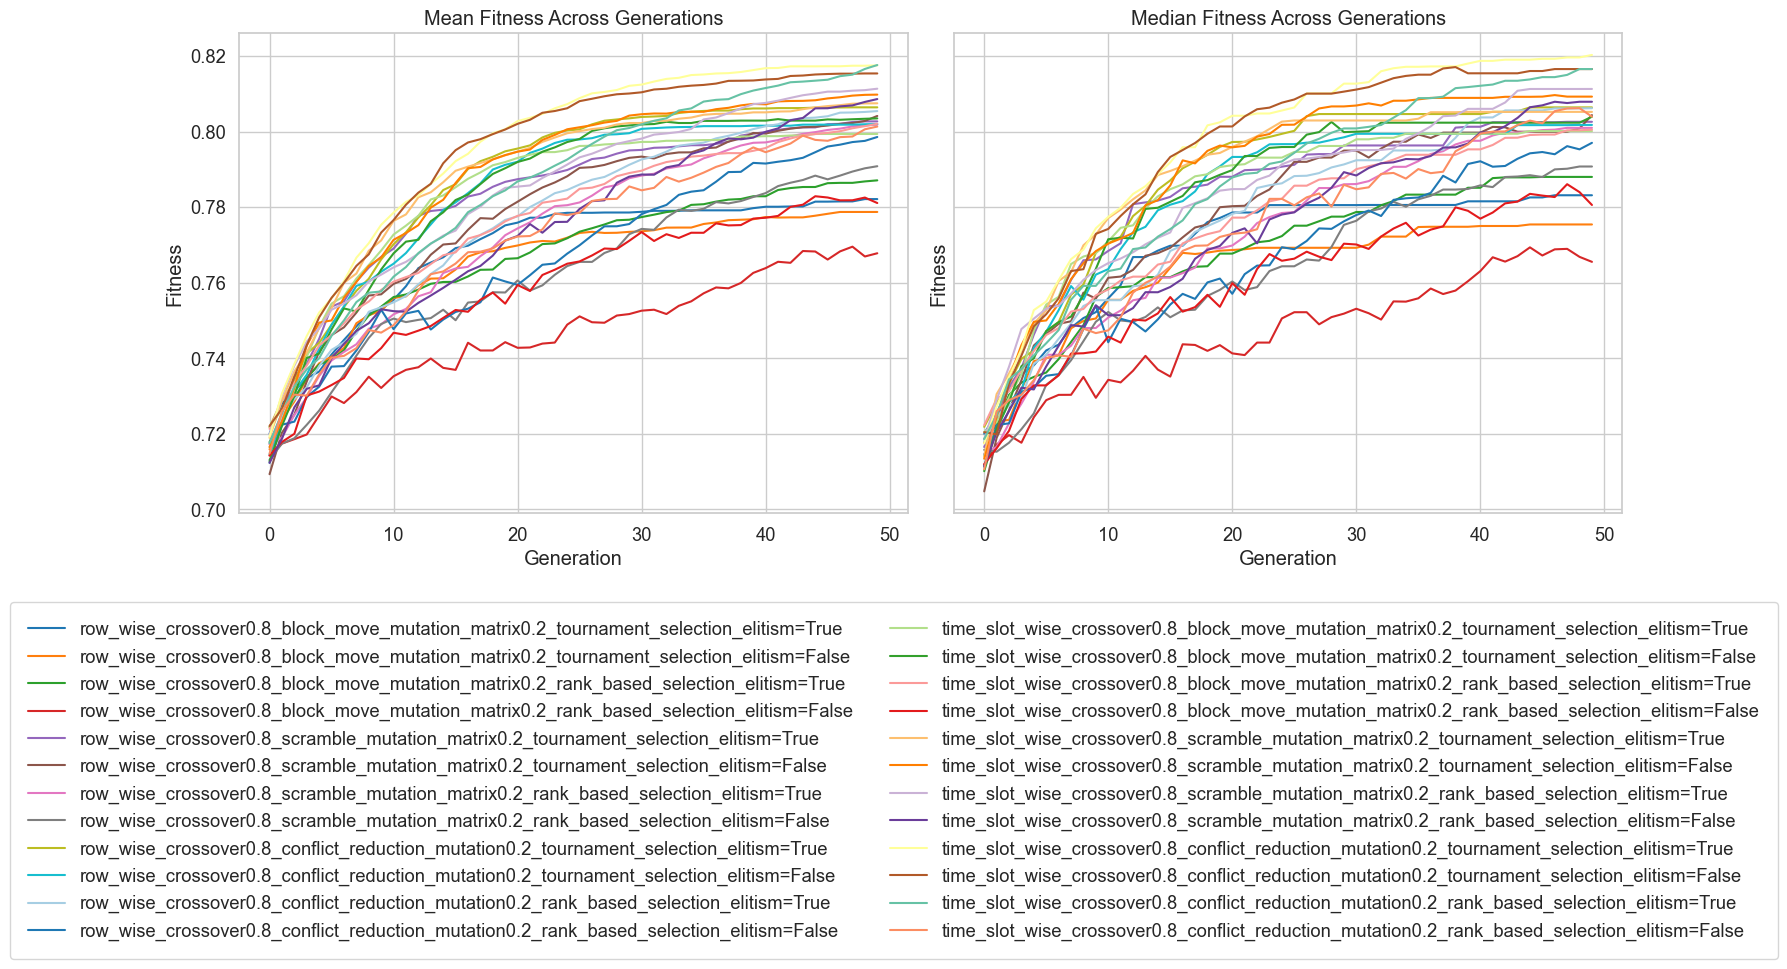

In [89]:
plot_fitness_over_gen(fitness_dfs)

The initial graph is somewhat difficult to interpret due to the many lines representing the 24 different configurations. However, some early insights can already be drawn:

In the initial stages of evolution, differences between configurations are subtle. As evolution progresses, it becomes clearer that the **best-performing configurations** (yellow and brown lines) **use conflict reduction mutation and time slot crossover**. This suggests that conflict-reduction mutation is more effective than the other mutation functions for this specific problem, which makes sense, as the conflict-reduction mutation was specifically designed with this problem’s constraints in mind. Time slot also looks to be more effective than row crossover, that also makes sense as it helps preserve high diversity genre and low conflict across generations. 

In [41]:
crossover_names = ["row_wise_crossover", "time_slot_wise_crossover"]
mutation_names = ["block_move_mutation_matrix", "scramble_mutation_matrix", "conflict_reduction_mutation"]
selection_names = ["tournament_selection", "rank_based_selection"]
elitism_names = [True, False]


crossover_fit_dfs = {}
mutation_fit_dfs = {}
selection_fit_dfs = {}
elitism_fit_dfs = {}

# Combine all isolated runs using a given crossover
for crossover_name in crossover_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if crossover_name in df_name:
            dfs_to_concat.append(df)

    crossover_fit_dfs[crossover_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

# Combine all isolated runs using a given mutation
for mutation_name in mutation_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if mutation_name in df_name:
            dfs_to_concat.append(df)
    mutation_fit_dfs[mutation_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

# Combine all isolated runs using a given selection
for selection_name in selection_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if selection_name in df_name:
            dfs_to_concat.append(df)

    selection_fit_dfs[selection_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

# Combine all isolated runs using elitism
for elitism_name in elitism_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if str(elitism_name) in df_name:
            dfs_to_concat.append(df)

    elitism_fit_dfs[elitism_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

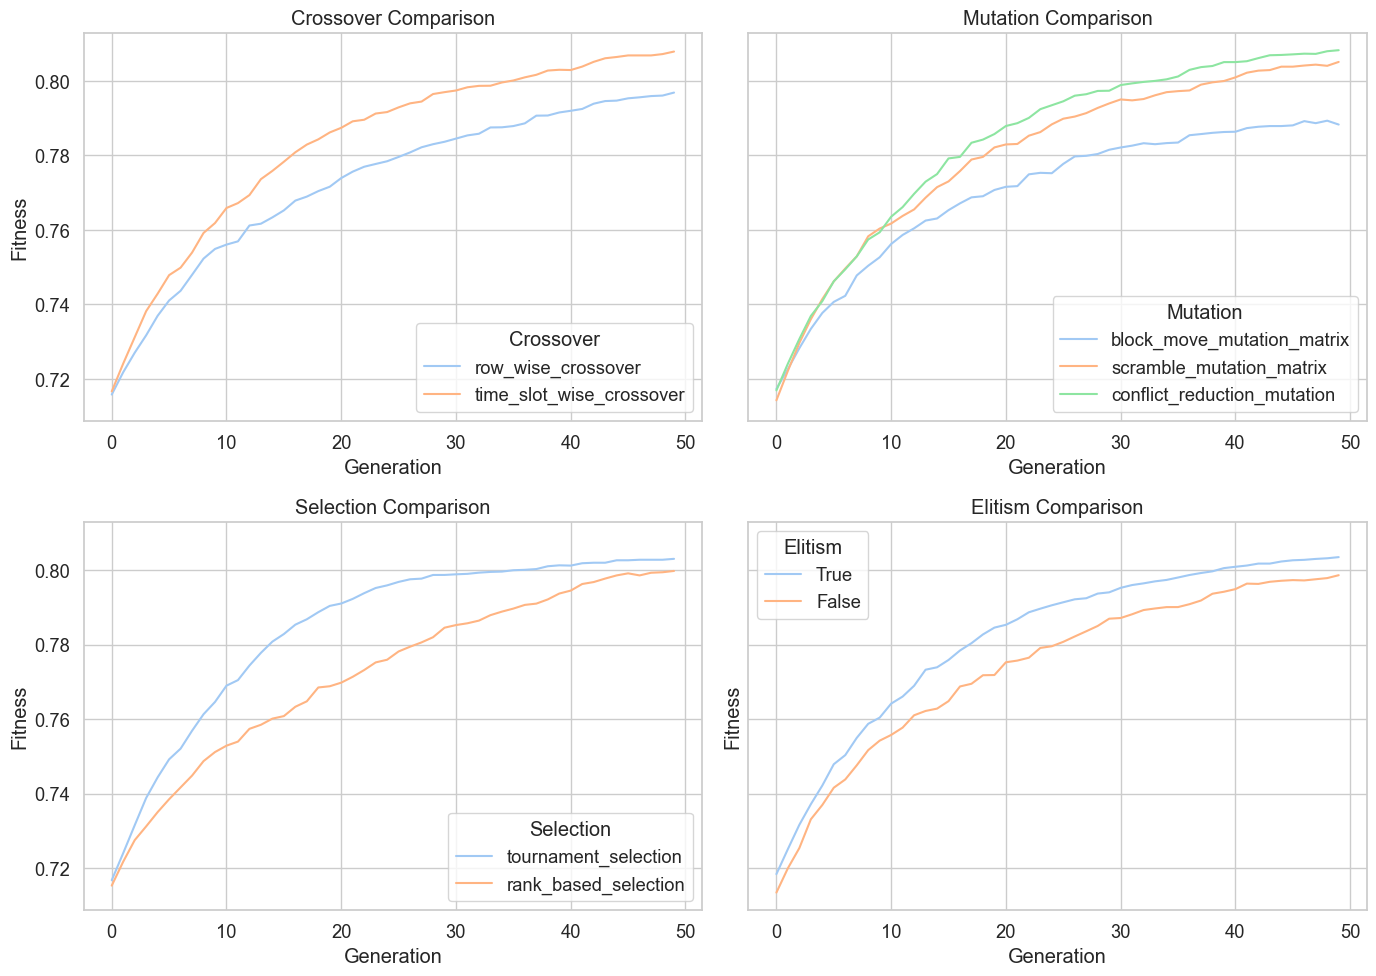

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# Plot crossover results
for name, df in crossover_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[0,0].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[0,0].set_title("Crossover Comparison")
axes[0,0].set_xlabel("Generation")
axes[0,0].set_ylabel("Fitness")
axes[0,0].legend(title="Crossover")
axes[0,0].grid(True)

# Plot mutation results
for name, df in mutation_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[0, 1].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[0, 1].set_title("Mutation Comparison")
axes[0, 1].set_xlabel("Generation")
axes[0, 1].legend(title="Mutation")
axes[0, 1].grid(True)

# Plot selection results
for name, df in selection_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[1,0].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[1,0].set_title("Selection Comparison")
axes[1,0].set_xlabel("Generation")
axes[1,0].set_ylabel("Fitness")
axes[1,0].legend(title="Selection")
axes[1,0].grid(True)

# Plot elitism results
for name, df in elitism_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[1,1].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[1,1].set_title("Elitism Comparison")
axes[1,1].set_xlabel("Generation")
axes[1,1].set_ylabel("Fitness")
axes[1,1].legend(title="Elitism")
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

#### Comparative Analysis of Genetic Operators

##### Crossover
Both crossover methods perform similarly in early generations, but time-slot-wise crossover shows better results as evolution progresses. This makes sense as in later generations, good individuals often already have strong time-slot structures with high *genre diversity* and *low conflict*. Swapping entire columns helps preserve these good patterns, making time-slot-wise crossover more effective for fine-tuning lineups than row-wise crossover, which can disrupt temporal organization.

##### Mutation
Among the three, conflict-reduction mutation performs best, followed closely by scramble. This aligns with expectations as conflict-reduction directly targets one of the main objectives, so it's naturally more impactful. Scramble adds useful local variation without disrupting structure too much, which helps with fine-tuning. Block-move, while good for early exploration, tends to perform worse later since it makes large changes that can undo progress in well-optimized individuals.


##### Selection
As expected, tournament_selection shows faster initial improvements, while rank-based selection evolves more steadily. This matches their characteristics, tournament is more exploitative, quickly favouring strong individuals, which speeds up early gains. Rank-based is more balanced, maintaining diversity longer by giving weaker individuals a chance, leading to a more stable and gradual evolution. 

##### Elitism
Having elitism enabled performed better than disabling it, which aligns with expectations. By preserving the best individuals each generation, elitism ensures that high-quality solutions are not lost due to random changes.


In [150]:
def compare_functions(fit_dfs, title):
    """
    Compare different functions present in the provided dictionary, using
    normality tests to decide between parametric (t-test) and non-parametric (Mann-Whitney U) test.
    
    Parameters:
        fit_dfs (dict): A dictionary mapping configuration names to DataFrames of fitness values.
        title (str): A title to identify the category.
    """
    print(f"\nStatistical comparisons for {title}:\n" + "-" * 50)
          
    for (label1, df1), (label2, df2) in combinations(fit_dfs.items(), 2):
        data1 = df1.values.flatten()
        data2 = df2.values.flatten()
    
        # Check if both sets look normally distributed
        stat1, p_norm1 = shapiro(data1)
        stat2, p_norm2 = shapiro(data2)
    
        print(f"\nComparing {label1} and {label2}:")
        print(f"  Normality test p-values: {label1} = {p_norm1:.4f}, {label2} = {p_norm2:.4f}")
    
        # Pick the right test depending on normality results
        if p_norm1 > 0.05 and p_norm2 > 0.05:
            # Both normal — go with t-test
            stat, p_val = ttest_ind(data1, data2, equal_var=False)
            test_used = "T-Test"
        else:
            # At least one isn't normal, use Mann-Whitney U test
            stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
            test_used = "Mann-Whitney U"
    
        print(f"  {test_used} p-value: {p_val:.4f}")
    
        if p_val < 0.05:
            print("  Result: Statistically significant difference found!")
        else:
            print("  Result: No significant difference detected.")

In [151]:
compare_functions(crossover_fit_dfs, "Crossover")
compare_functions(mutation_fit_dfs, "Mutation")
compare_functions(selection_fit_dfs, "Selection")
compare_functions(elitism_fit_dfs, "Elitism")


Statistical comparisons for Crossover:
--------------------------------------------------

Comparing row_wise_crossover and time_slot_wise_crossover:
  Normality test p-values: row_wise_crossover = 0.0000, time_slot_wise_crossover = 0.0000
  Mann-Whitney U p-value: 0.0000
  Result: Statistically significant difference found!

Statistical comparisons for Mutation:
--------------------------------------------------

Comparing block_move_mutation_matrix and scramble_mutation_matrix:
  Normality test p-values: block_move_mutation_matrix = 0.0000, scramble_mutation_matrix = 0.0000
  Mann-Whitney U p-value: 0.0000
  Result: Statistically significant difference found!

Comparing block_move_mutation_matrix and conflict_reduction_mutation:
  Normality test p-values: block_move_mutation_matrix = 0.0000, conflict_reduction_mutation = 0.0000
  Mann-Whitney U p-value: 0.0000
  Result: Statistically significant difference found!

Comparing scramble_mutation_matrix and conflict_reduction_mutation:
 

C:\Users\Bárbara C\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12000.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Bárbara C\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8000.
  res = hypotest_fun_out(*samples, **kwds)


All pairwise comparisons between the different genetic operators and elitism configurations show statistically significant differences in performance (p-values < 0.05), according to the Mann-Whitney U test. This means that the choice of crossover method, mutation strategy, selection method, and whether elitism is enabled or not, all have a meaningful impact on the evolutionary algorithm's results.

In [155]:
def compare_top_configs_median(fitness_dfs, top_n=3):
    # Calculate median final generation fitness per configuration
    final_gen_medians = {}
    for label, df in fitness_dfs.items():
        final_gen_values = df[GENERATIONS - 1].values  # last generation fitness from all runs
        final_gen_medians[label] = np.median(final_gen_values)
    
    # Sort configs by descending median fitness, best first
    sorted_configs = sorted(final_gen_medians.items(), key=lambda x: x[1], reverse=True)
    top_configs = [cfg for cfg, _ in sorted_configs[:top_n]]
    
    print(f"Top {top_n} configurations by median final fitness:")
    for cfg in top_configs:
        values = fitness_dfs[cfg][GENERATIONS - 1].values
        print(f"{cfg}: Median = {np.median(values):.4f}, Std Dev = {np.std(values):.4f}")
    
    print("\nPairwise statistical comparisons between top configs:\n" + "-"*60)
    
    # Compare every pair from the top configs
    for cfg1, cfg2 in combinations(top_configs, 2):
        data1 = fitness_dfs[cfg1][GENERATIONS - 1].values
        data2 = fitness_dfs[cfg2][GENERATIONS - 1].values
        
        # Test normality with Shapiro-Wilk test
        stat1, p_norm1 = shapiro(data1)
        stat2, p_norm2 = shapiro(data2)
        
        print(f"\nComparing:\n  {cfg1}\n  {cfg2}")
        print(f"  Normality p-values: {cfg1}: {p_norm1:.4f}, {cfg2}: {p_norm2:.4f}")
        
        # If both normal, use t-test, else Mann-Whitney U
        if p_norm1 > 0.05 and p_norm2 > 0.05:
            # Parametric test
            stat, p_val = ttest_ind(data1, data2, equal_var=False)
            test_name = "T-Test"
        else:
            # Non-parametric test
            stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
            test_name = "Mann-Whitney U"
        
        print(f"  {test_name} p-value: {p_val:.4f}")
        if p_val < 0.05:
            print("  => Statistically significant difference (p < 0.05)")
        else:
            print("  => No significant difference (p >= 0.05)")



In [171]:
compare_top_configs_median(fitness_dfs, top_n=4)

Top 4 configurations by median final fitness:
time_slot_wise_crossover0.8_conflict_reduction_mutation0.2_tournament_selection_elitism=True: Median = 0.8203, Std Dev = 0.0105
time_slot_wise_crossover0.8_conflict_reduction_mutation0.2_rank_based_selection_elitism=True: Median = 0.8166, Std Dev = 0.0064
time_slot_wise_crossover0.8_conflict_reduction_mutation0.2_tournament_selection_elitism=False: Median = 0.8166, Std Dev = 0.0118
time_slot_wise_crossover0.8_scramble_mutation_matrix0.2_rank_based_selection_elitism=True: Median = 0.8113, Std Dev = 0.0062

Pairwise statistical comparisons between top configs:
------------------------------------------------------------

Comparing:
  time_slot_wise_crossover0.8_conflict_reduction_mutation0.2_tournament_selection_elitism=True
  time_slot_wise_crossover0.8_conflict_reduction_mutation0.2_rank_based_selection_elitism=True
  Normality p-values: time_slot_wise_crossover0.8_conflict_reduction_mutation0.2_tournament_selection_elitism=True: 0.2997, ti

##### Top Configurations & Statistical Comparison

From the top 4 configurations (by median final fitness), the best-performing ones all use **time-slot-wise crossover** and **conflict-reduction mutation**, with slight differences in selection method and whether elitism was enabled or not.

In most cases, differences were **not statistically significant**, which makes sense given how close their medians are. The only significant result was between the top config and the one using `scramble_mutation`, suggesting that **conflict-reduction mutation gives a real edge** over more general strategies.

This supports the idea that while selection and elitism do help, **mutation type has the biggest impact** on performance in the final stages.

In [51]:
grid_params = {
    "xo_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)],
    "mut_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
}

finetune_fitness_results = {}

for xo_prob in grid_params["xo_prob"]:
    for mut_prob in grid_params["mut_prob"]:
        config_results = []

        for run_nr in range(20):
            best_solution, _ = genetic_algorithm(
                initial_population=[
                ArtistLineupSolutionGA(
                    crossover_function=time_slot_wise_crossover,
                    mutation_function=conflict_reduction_mutation,
                    conflict_matrix=conflict_matrix,
                    artists=artists
                ) for _ in range(POP_SIZE)
            ],
            max_gen=GENERATIONS,
            selection_algorithm=tournament_selection,
            maximization=True,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=True
            )
            config_results.append(best_solution.fitness())

        # Create a label for the config
        config_label = f"xo_prob={round(xo_prob, 2)}_mut_prob={round(mut_prob, 2)}"
    
        finetune_fitness_results[config_label] = config_results

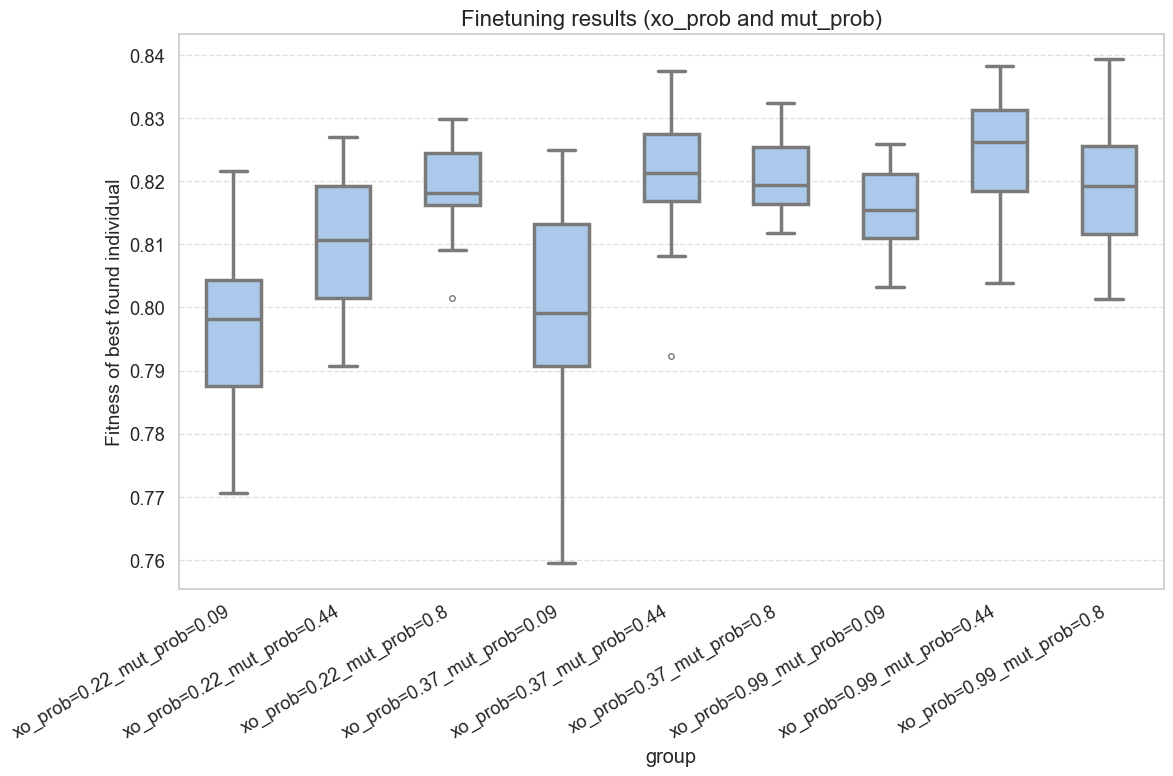

In [172]:
# Convert the results into a long-format DataFrame for Seaborn
data = []
for config_label, fitness_values in finetune_fitness_results.items():
    for value in fitness_values:
        data.append({
            'value': value,
            'group': config_label
        })

df_long = pd.DataFrame(data)

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='group', y='value', data=df_long, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Finetuning results (xo_prob and mut_prob)', fontsize=16)
plt.ylabel('Fitness of best found individual', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

The results suggest that fine-tuning the crossover and mutation probabilities has a significant impact on the overall performance of the GA.

Across the tested parameter combinations, the distribution of the best-found fitness values on the last generations shows clear distinctions, indicating noticeable performance variations. For instance, combinations with xo_prob=0.9generallyly achieve higher median fitness valu and more compact and stable variationsns compared to xo_prob=0. and xo_prob=0.372
2

This indicates that the algorithm's performance is sensitive to these hyperparameters, particularly the crossover probability. Specifically, a high crossover probability (xo_prob=0.99) combined with moderate mutation probabilities (mut_prob=0.09 or mut_prob=0.44) consistently leads to superior results. Conversely, a low crossover rate, especially coupled with a low mutation rate, significantly impairs the optimization outcome, highlighting the importance of proper hyperparameter selection.